In [71]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn_pandas import DataFrameMapper
import warnings
from collections import defaultdict

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [72]:
TANKS_STR = 'M98, M508, M727, M520, K85, K58, K13, K7, K74, K75, K64, F225, F292, F241, F453, F464, F165, F182, F334, F88'
TANKS = [x.strip() for x in TANKS_STR.split(',')]
TANK_FACTORIES = [x[0] for x in TANKS]
TANK_FACTORY_NUMBERS = [ord(x) - ord('A') + 1 for x in TANK_FACTORIES]
TANK_NUMBERS = [int(x[1:]) for x in TANKS]
TANK_NUMBERS_BY_FACTORY = defaultdict(list)
for f, x in zip(TANK_FACTORIES, TANK_NUMBERS):
    TANK_NUMBERS_BY_FACTORY[f].append(x)

In [12]:
def MLE(tank_numbers):
    return max(tank_numbers)

MLE(TANK_NUMBERS)

727

In [61]:
# Inspired by the code in http://www.greenteapress.com/thinkbayes/thinkbayes.pdf

class TankEstimator(object):
    def __init__(self, prior_values, prior_probabilities=None):
        self.theta_values = prior_values
        self.probability_history = []
        
        if prior_probabilities:
            self.theta_probabilities = prior_probabilities
            self.normalize()
        else:
            # Uniform prior
            self.theta_probabilities = [1.0] * len(self.theta_values)
            self.normalize()
            
        

    def likelihood(self, x):
        return [ 0 if (x > p) else 1.0/p for p in self.theta_values]
    
    def normalize(self):
        n = sum(self.theta_probabilities)
        self.theta_probabilities = [p / n for p in self.theta_probabilities]
        self.probability_history.append(self.theta_probabilities[:])
            
    def update(self, values):
        try:
            for x in values:
                self.theta_probabilities = [p * l for p, l in zip(self.theta_probabilities, self.likelihood(x))]
                self.normalize()
                
        except TypeError: # not iterable
            x = values
            self.theta_probabilities = [p * l for p, l in zip(self.theta_probabilities, self.likelihood(x))]
            self.normalize()
    
    def plot(self):
        plt.figure(figsize=(12, 9))
        n = len(self.probability_history)
        for (i, probs) in enumerate(self.probability_history):
            # TODO: consider using a color scale
            if i == 0:
                plt.plot(self.theta_values, probs, alpha=(0.2 + 0.8 * (i + 1) / n), lw=4, label='Prior')
            
            if i == n - 1:
                plt.plot(self.theta_values, probs, alpha=(0.2 + 0.8 * (i + 1) / n), lw=4, label='Posterior')
                
            else:
                plt.plot(self.theta_values, probs, alpha=(0.2 + 0.8 * (i + 1) / n))
            
        plt.legend(loc=1, fontsize=16)
        xmin, xmax = plt.xlim()
        plt.xlim(-0.01, xmax)
        plt.xlabel(r'$\theta$', size=16)
        plt.ylabel(r'$P(\theta|x)$', size=16)
        plt.show()
        
    def mean(self):
        return sum([t * p for t, p in zip(self.theta_values, self.theta_probabilities)])


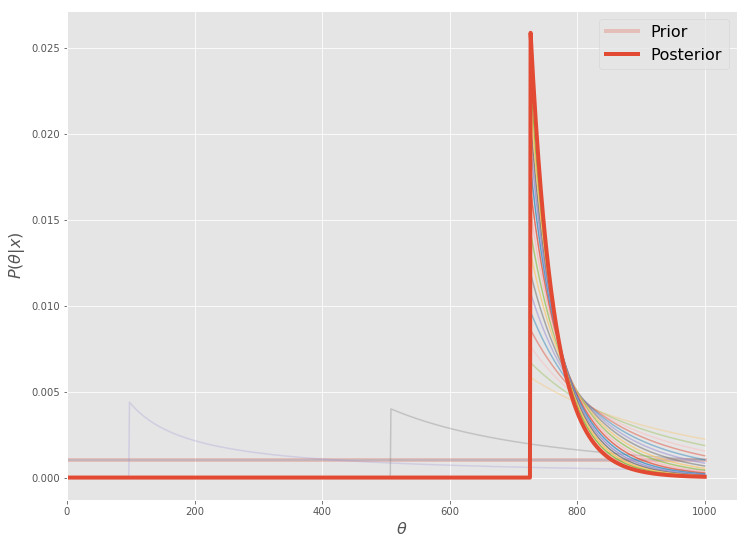

766.20030481528


In [74]:
tanks_1000 = TankEstimator(list(range(1, 1001)))
tanks_1000.update(TANK_NUMBERS)
tanks_1000.plot()
print(tanks_1000.mean())

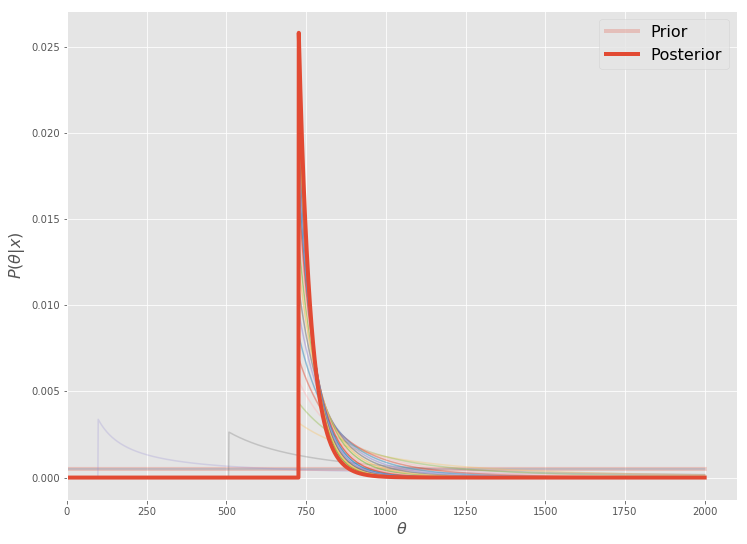

766.8634056547036


In [75]:
tanks_2000 = TankEstimator(list(range(1, 2001)))
tanks_2000.update(TANK_NUMBERS)
tanks_2000.plot()
print(tanks_2000.mean())

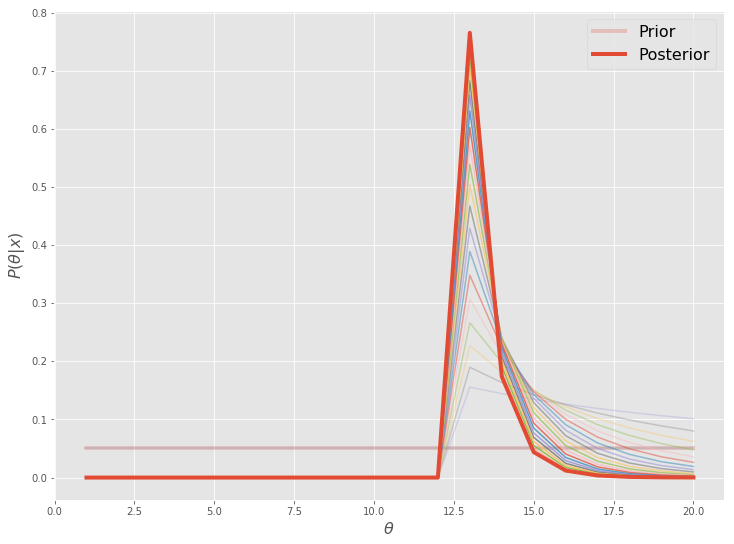

13.320670316951476


In [70]:
tank_factories = TankEstimator(list(range(1, 21)))
tank_factories.update(TANK_FACTORY_NUMBERS)
tank_factories.plot()
print(tank_factories.mean())

In [73]:
factory_models = {}
for factory in set(TANK_FACTORIES):
    model = TankEstimator(list(range(1, 1001)))
    model.update(TANK_NUMBERS_BY_FACTORY[factory])
    print('{f}: {m:.3f}'.format(f=factory, m=model.mean()))
    factory_models[factory] = model


M: 834.760
K: 101.407
F: 528.411


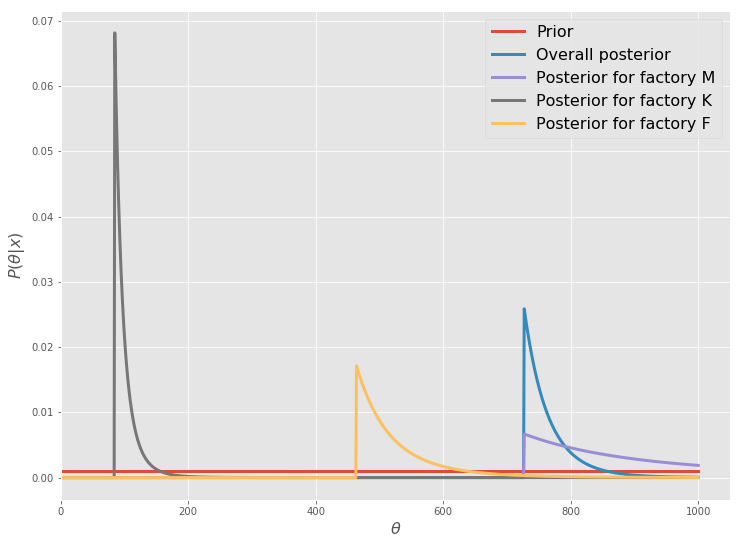

In [76]:
theta_values = tanks_1000.theta_values

plt.figure(figsize=(12, 9))
plt.plot(theta_values, tanks_1000.probability_history[0], lw=3, label='Prior')
plt.plot(theta_values, tanks_1000.theta_probabilities, lw=3, label='Overall posterior')
for factory, model in factory_models.items():
    plt.plot(theta_values, model.theta_probabilities, lw=3, label='Posterior for factory {f}'.format(f=factory))

plt.legend(loc=1, fontsize=16)
xmin, xmax = plt.xlim()
plt.xlim(-0.01, xmax)
plt.xlabel(r'$\theta$', size=16)
plt.ylabel(r'$P(\theta|x)$', size=16)
plt.show()

In [115]:
from sklearn.datasets import make_blobs

sample_data, centers = make_blobs(1100, centers=5)
test_data = sample_data[1000:]
sample_data = sample_data[:1000]

sample_x = list(zip(*sample_data))[0]
sample_y = list(zip(*sample_data))[1]

test_x = list(zip(*test_data))[0]
test_y = list(zip(*test_data))[1]



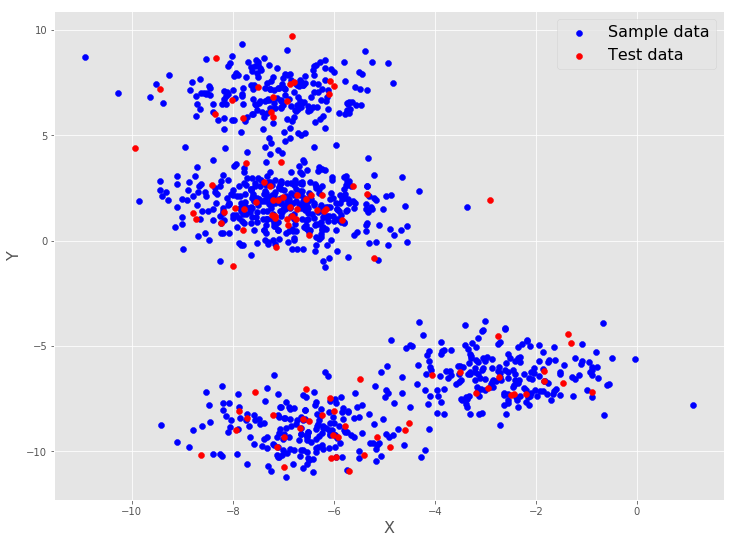

In [118]:
plt.figure(figsize=(12, 9))

plt.scatter(sample_x, sample_y, color='blue', label='Sample data')
plt.scatter(test_x, test_y, color='red', label='Test data')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'X', size=16)
plt.ylabel(r'Y', size=16)
plt.show()

In [119]:
from sklearn.mixture import GaussianMixture

def fit_and_plot_mixture(n_components):
    mixture = GaussianMixture(n_components=n_components)
    mixture.fit(sample_data)
    pred = mixture.predict(sample_data)
    print(n_components, ':')
    print('Sample data:', mixture.score(sample_data), mixture.bic(sample_data))
    print('Test data:', mixture.score(test_data), mixture.bic(test_data))
    
    plt.figure(figsize=(12, 9))

    for i in range(n_components):
        plt.scatter(np.take(sample_x, np.where(pred == i)), np.take(sample_y, np.where(pred == i)), 
                    label='Component {i}'.format(i=i + 1))

    plt.legend(loc=1, fontsize=16)
    plt.xlabel(r'X', size=16)
    plt.ylabel(r'Y', size=16)
    plt.show()


1 :
Sample data: -5.16976466768 10374.0681118
Test data: -5.20806132212 1064.63811535


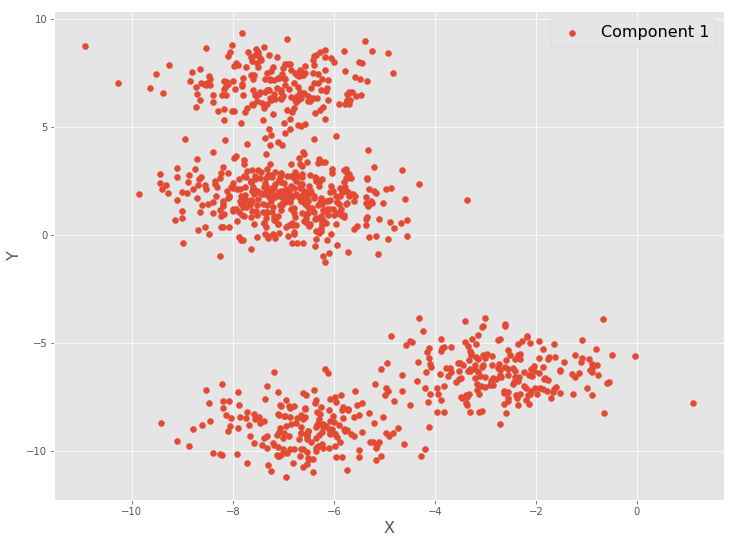

2 :
Sample data: -4.50324209746 9082.46950299
Test data: -4.5581638092 962.289633885


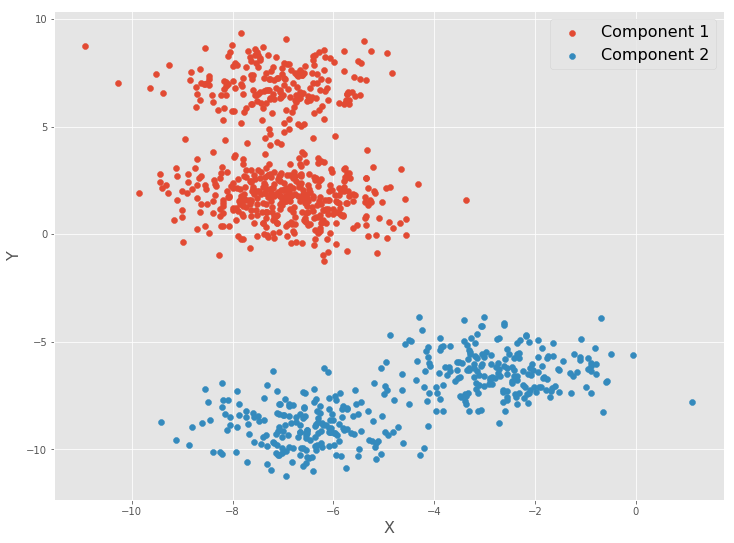

3 :
Sample data: -4.29906549655 8715.56283284
Test data: -4.3575238654 949.792666241


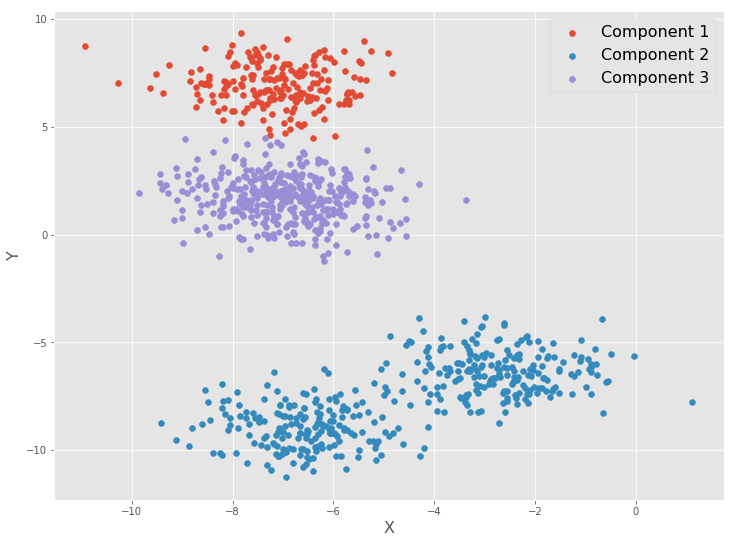

4 :
Sample data: -4.1957970754 8550.47252222
Test data: -4.26121157056 958.161228389


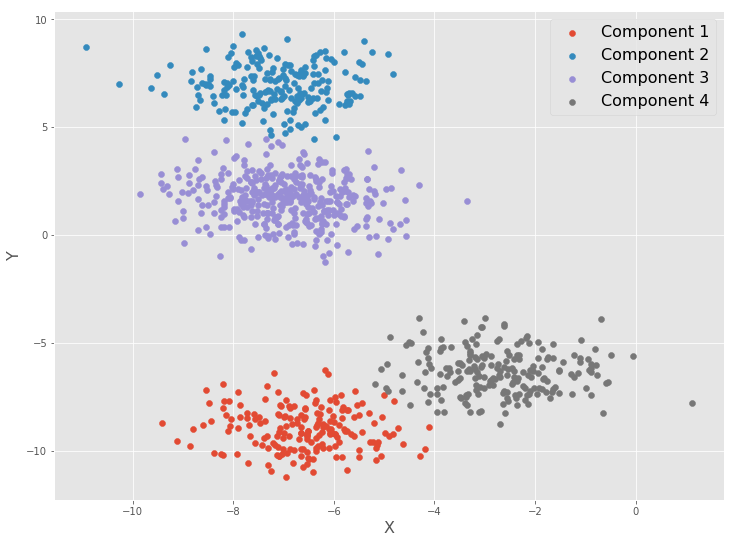

5 :
Sample data: -4.19704757814 8594.42005937
Test data: -4.28074799075 989.699533545


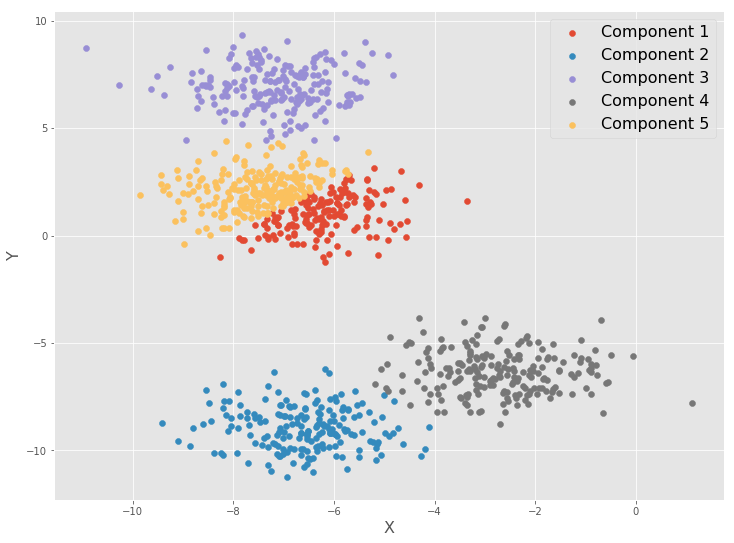

6 :
Sample data: -4.19513478829 8632.04101135
Test data: -4.28465754411 1018.11246533


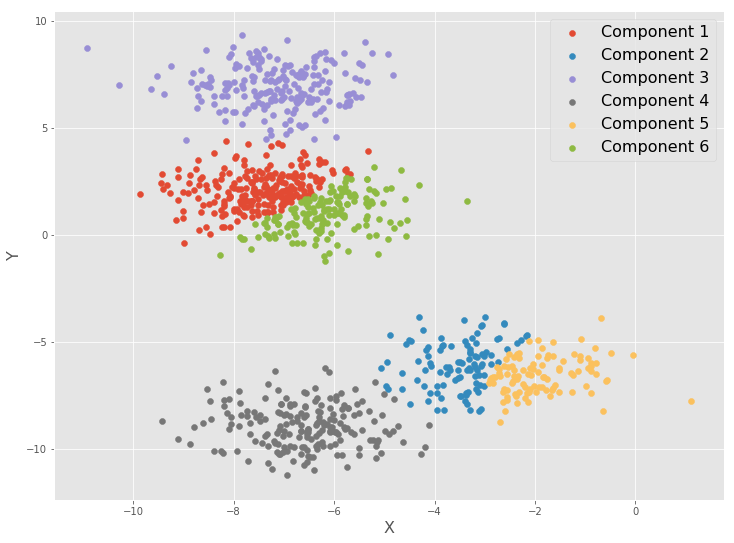

7 :
Sample data: -4.1943489167 8671.91579983
Test data: -4.28350807754 1045.51359313


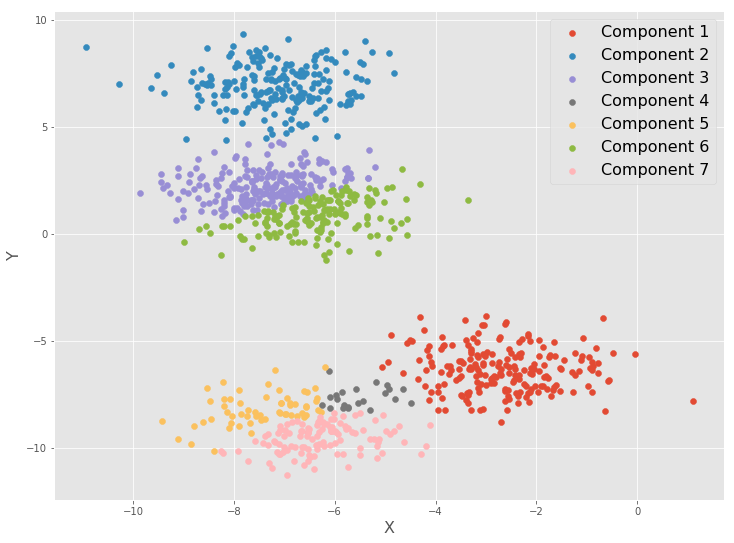

8 :
Sample data: -4.19011028105 8704.8850602
Test data: -4.30049848253 1076.54269525


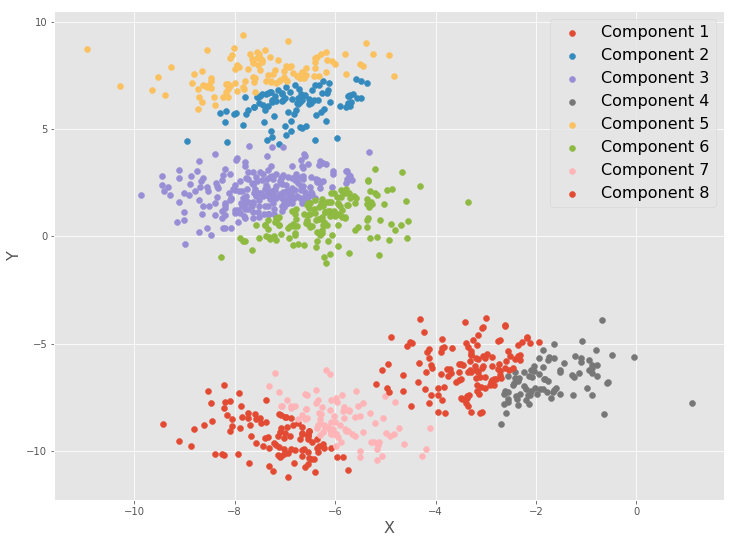

9 :
Sample data: -4.18741089914 8740.93282807
Test data: -4.28216255997 1100.50653185


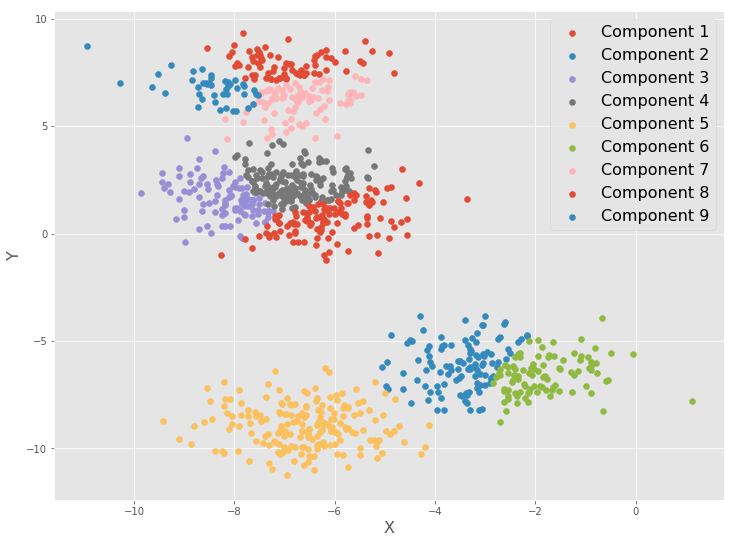

In [120]:
for i in range(1, 10):
    fit_and_plot_mixture(i)